In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import collections


if "../" not in sys.path:
  sys.path.append("../") 

In [2]:
from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

## Environment declaration

In [3]:
env = CliffWalkingEnv()

## Q-learning

### search action by epsilon greedy 

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    #should return function!!!
    def policy_fn(observation):
        A = np.ones(nA, dtype= float) * epsilon/nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0-epsilon)
        return A
    return policy_fn

### Q-value update

In [5]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in range(0,5000): #itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

In [6]:
#run q learning
Q, statsqlearning = q_learning(env, 300)

Episode 300/300.

### SARSA

In [7]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [8]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in range(0,5000): #itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Pick the next action
            # in Q learning here is the best_next_action = argmax[next_state]
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

In [9]:
#run sarsa
Q, statssarsa = sarsa(env, 300)

Episode 300/300.

## Actor Critic

In [10]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [11]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [12]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in range(0,5000):#itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [13]:
#run actor critic
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~300 seemed to work well for me.
    statsac = actor_critic(env, policy_estimator, value_estimator, 300)

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step 12 @ Episode 300/300 (-13.0))

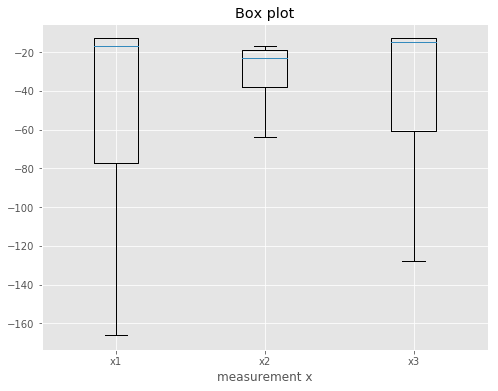

In [14]:
from matplotlib import pyplot as plt

x1 = statsqlearning.episode_rewards
x2 = statssarsa.episode_rewards
x3 = statsac.episode_rewards

fig = plt.figure(figsize=(8,6))

plt.boxplot([x for x in [x1, x2, x3]], 0, 'rs', 1, showfliers = False)
plt.xticks([y+1 for y in range(len([x1, x2, x3]))], ['x1', 'x2', 'x3'])
plt.xlabel('measurement x')
t = plt.title('Box plot')
plt.show()

In [15]:
import statistics
print("Stats for Q-learning")
print("Best", max(x1))
print("Worst", min(x1))
print("Median", statistics.median(x1))
print("Standard Deviation", statistics.stdev(x1))

Stats for Q-learning
Best -13.0
Worst -228.0
Median -17.0
Standard Deviation 43.14186445006086


In [16]:
print("Stats for SARSA")
print("Best", max(x2))
print("Worst", min(x2))
print("Median", statistics.median(x2))
print("Standard Deviation", statistics.stdev(x2))

Stats for SARSA
Best -17.0
Worst -226.0
Median -23.0
Standard Deviation 37.24204238885402


In [17]:
print("Stats for Actor Critic")
print("Best", max(x3))
print("Worst", min(x3))
print("Median", statistics.median(x3))
print("Standard Deviation", statistics.stdev(x3))

Stats for Actor Critic
Best -13.0
Worst -765.0
Median -15.0
Standard Deviation 100.85045337770323


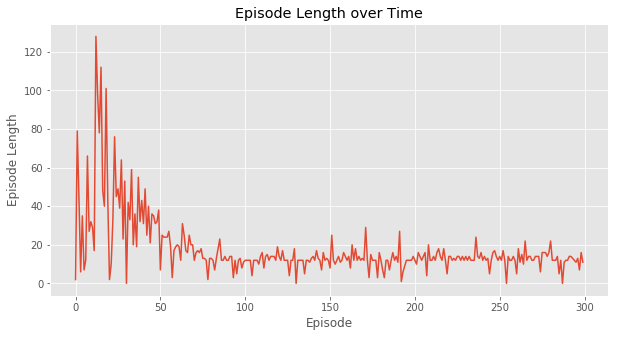

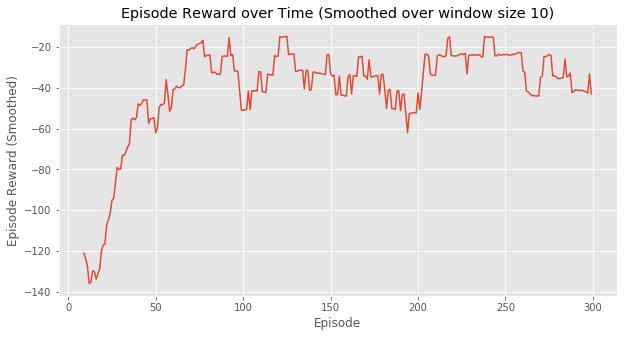

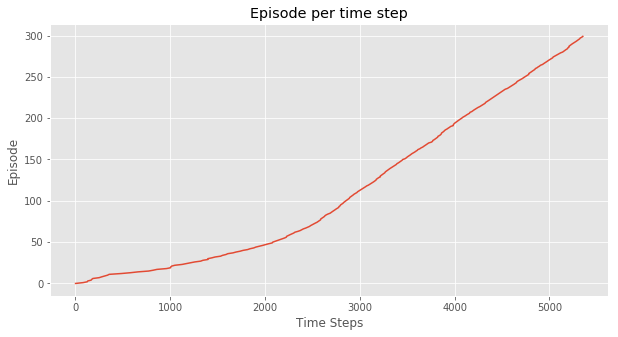

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [18]:
plotting.plot_episode_stats(statsqlearning)

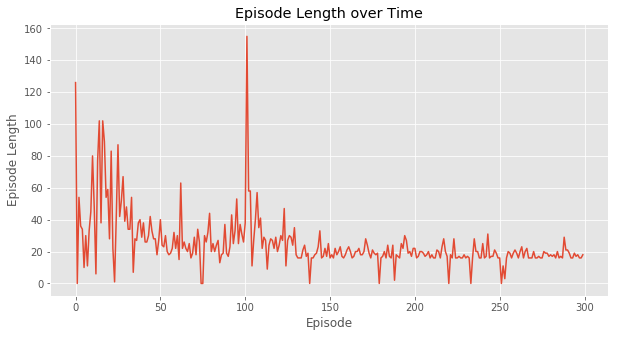

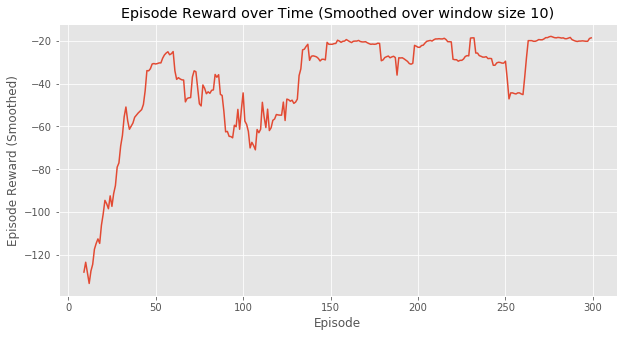

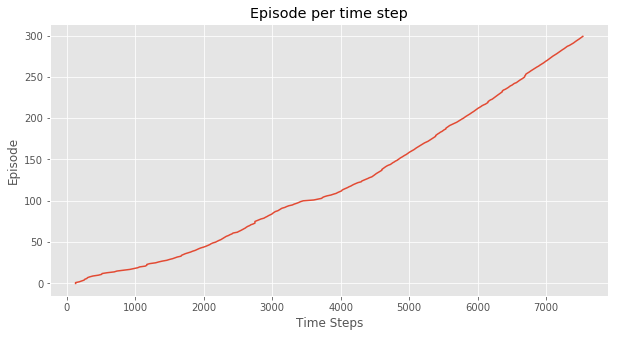

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [19]:
plotting.plot_episode_stats(statssarsa)

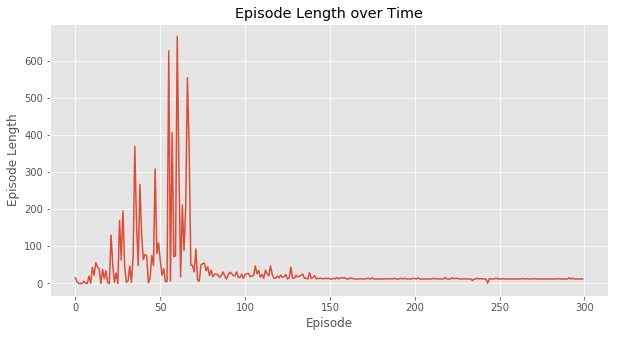

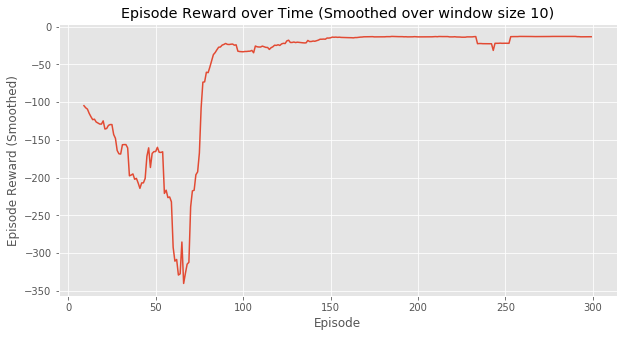

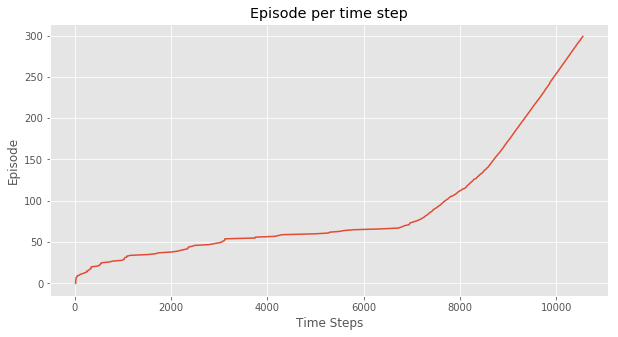

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [20]:
plotting.plot_episode_stats(statsac)